<a href="https://colab.research.google.com/github/Giant-Leap-ai/AAI-521FinalProject-dev/blob/dev/Team_Assignment_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Required Libraries

In [40]:
!pip install opencv-python matplotlib numpy --quiet
import numpy as np
import pandas as pd
import os
import kagglehub
import matplotlib.pyplot as plt
import cv2


### Upoad Dataset from Kagglehub

In [20]:
extract_dir = kagglehub.dataset_download("simongraves/selfie-and-id-dataset")
print("Dataset directory:", extract_dir)

target_name = "Selie_ID.csv"
csv_path = None

for root, dirs, files in os.walk(extract_dir):
    if target_name in files:
        csv_path = os.path.join(root, target_name)
        break

if csv_path is None:
    raise FileNotFoundError(f"{target_name} not found under {extract_dir}")

df = pd.read_csv(csv_path, sep=";")
df.head()

Using Colab cache for faster access to the 'selfie-and-id-dataset' dataset.
Dataset directory: /kaggle/input/selfie-and-id-dataset


set_id  age  gender       country       ethnicity     device_model  \
0       1   45  FEMALE       Ukraine        European      Samsung M31   
1       2   24    MALE     Pakistan            Asian   Infinix note11   
2       3   35    MALE        Egypt   Middle Eastern  Infinix note 10   
3       4   19  FEMALE      Nigeria          African      Tecno Pop 7   
4       5   31  FEMALE  South Africa         African      Samsung A05   

   age_printed_1  age_printed_2 1_id_photo_resolution 2_id_photo_resolution  \
0             16             25            962 x 1000            907 x 1000   
1             18             23            1000 x 750            1000 x 750   
2             33             34            1000 x 750            1000 x 748   
3             18             18            750 x 1000            1000 x 750   
4             25             17            1000 x 750            1000 x 750   

   ... 4_selfie_photo_extension 5_selfie_photo_extension  \
0  ...                      jpg                      jpg   
1  ...                      jpg                      jpg   
2  ...                      jpg                      jpg   
3  ...                      jpg                      jpg   
4  ...                      jpg                      jpg   

  6_selfie_photo_extension 7_selfie_photo_extension 8_selfie_photo_extension  \
0                      jpg                      jpg                      jpg   
1                      jpg                      jpg                      jpg   
2                      jpg                      jpg                      jpg   
3                      jpg                      jpg                      jpg   
4                      jpg                      jpg                      jpg   

  9_selfie_photo_extension 10_selfie_photo_extension  \
0                      jpg                       jpg   
1                      jpg                       jpg   
2                      jpg                       jpg   
3                     jpeg                       jpg   
4                      jpg                       jpg   

  11_selfie_photo_extension 12_selfie_photo_extension  \
0                       jpg                       jpg   
1                       jpg                       jpg   
2                       jpg                       jpg   
3                      jpeg                       jpg   
4                       jpg                       jpg   

  13_selfie_photo_extension  
0                       jpg  
1                       jpg  
2                       jpg  
3                       jpg  
4                       jpg  

[5 rows x 38 columns]

### Explore Dataset Structure

In [21]:
# Count how many folders & files exist
for dirpath, dirnames, filenames in os.walk(extract_dir):
    print(dirpath, "->", len(filenames), "files")
    # stop early so it doesn't print 1000 lines
    if dirpath.count(os.sep) > extract_dir.count(os.sep) + 2:
        break


/kaggle/input/selfie-and-id-dataset -> 1 files
/kaggle/input/selfie-and-id-dataset/files -> 0 files
/kaggle/input/selfie-and-id-dataset/files/7 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/2 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/10 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/5 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/8 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/3 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/1 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/4 -> 15 files
/kaggle/input/selfie-and-id-dataset/files/9 -> 14 files
/kaggle/input/selfie-and-id-dataset/files/6 -> 15 files


### Missing values + basic sanity check

In [22]:
# Quick missing-value check in metadata
missing_counts = df.isna().sum().sort_values(ascending=False)
print("Missing values per column (top 10):")
print(missing_counts.head(10))


Missing values per column (top 10):
set_id                   0
age                      0
gender                   0
country                  0
ethnicity                0
device_model             0
age_printed_1            0
age_printed_2            0
1_id_photo_resolution    0
2_id_photo_resolution    0
dtype: int64


### Build Paths to Selfies

In [23]:
base_img_dir = os.path.join(extract_dir, "files")

def get_selfie_path(row: pd.Series, selfie_idx: int = 1) -> str:
    """
    Build the file path to a selfie image for a given person (row).

    Args:
        row (pd.Series): One row from the Selie_ID dataframe. Must contain
            'set_id' and the '<idx>_selfie_photo_extension' column.
        selfie_idx (int, optional): Which selfie to load (1–13).
            Defaults to 1 (first selfie).

    Returns:
        str: Absolute path to the selfie image on disk, e.g.
            '/content/data/selfie_and_id/files/1/Selfie_1.jpg'
    """
    set_id = row["set_id"]
    ext_col = f"{selfie_idx}_selfie_photo_extension"
    extension = row[ext_col]
    filename = f"Selfie_{selfie_idx}.{extension}"
    return os.path.join(base_img_dir, str(set_id), filename)


# Test:
get_selfie_path(df.iloc[0], selfie_idx=1)


'/kaggle/input/selfie-and-id-dataset/files/1/Selfie_1.jpg'

### Show Sample Images (Image Inspection)

Path: /kaggle/input/selfie-and-id-dataset/files/1/Selfie_1.jpg
Shape: (1000, 563, 3)


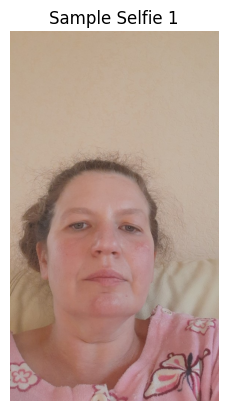

Path: /kaggle/input/selfie-and-id-dataset/files/2/Selfie_1.jpg
Shape: (1000, 750, 3)


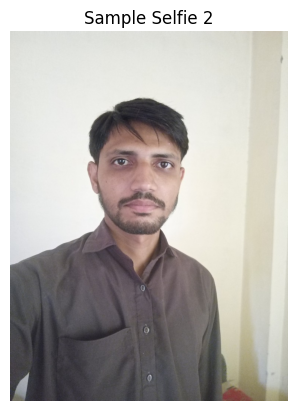

Path: /kaggle/input/selfie-and-id-dataset/files/3/Selfie_1.jpg
Shape: (1000, 750, 3)


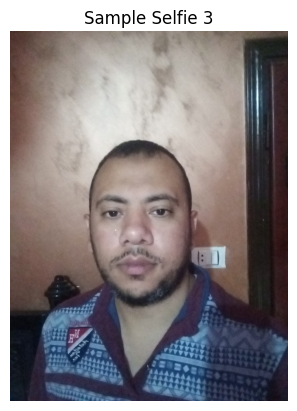

In [24]:
import cv2
import matplotlib.pyplot as plt

def show_image(path: str, title: str | None = None) -> None:
    """
    Load and display a single image using OpenCV + Matplotlib.

    Args:
        path (str): Full path to the image file.
        title (str, optional): Optional title for the plot.
            If None, no title is shown.

    Side effects:
        - Prints path and image shape (H, W, C).
        - Renders the image inline with axes turned off.
    """
    if not os.path.exists(path):
        print("Image not found:", path)
        return

    img = cv2.imread(path)                    # BGR
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print("Path:", path)
    print("Shape:", img_rgb.shape)

    plt.imshow(img_rgb)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# Show 3 sample images
for i in range(3):
    p = get_selfie_path(df.iloc[i], selfie_idx=1)
    show_image(p, title=f"Sample Selfie {i+1}")


### Resolution Distribution (EDA)

In [25]:
from collections import Counter
sizes = []

# check first 300 for speed
for i in range(min(300, len(df))):
    p = get_selfie_path(df.iloc[i], selfie_idx=1)
    img = cv2.imread(p)
    if img is not None:
        h, w = img.shape[:2]
        sizes.append((w, h))

Counter(sizes).most_common(10)


[((750, 1000), 5), ((563, 1000), 2), ((1000, 750), 2), ((1000, 1000), 1)]

### Minimal Preprocessing (Resize Helper)

(np.float64(-0.5), np.float64(287.5), np.float64(511.5), np.float64(-0.5))

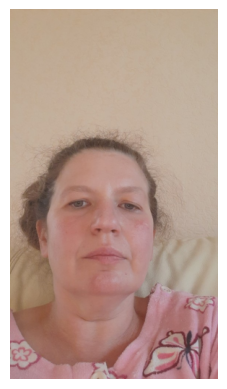

In [26]:
def load_and_resize(path: str, max_size: int = 512) -> np.ndarray | None:
    """
    Load an image from disk and optionally downscale it so that
    the longest side equals `max_size`.

    Args:
        path (str): Full path to the image file.
        max_size (int, optional): Target size for the longest edge in pixels.
            For example, max_size=512 ensures max(H, W) == 512.
            Defaults to 512.

    Returns:
        np.ndarray | None:
            - BGR image array of shape (H, W, 3) after resizing, or
            - None if the image failed to load.
    """
    img = cv2.imread(path)
    if img is None:
        return None

    h, w = img.shape[:2]
    scale = max_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return img_resized


sample = load_and_resize(get_selfie_path(df.iloc[0], 1))
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.axis("off")



### Hand-crafted sketch pipeline functions

In [27]:
def to_grayscale(img_bgr: np.ndarray) -> np.ndarray:
    """
    Convert a BGR color image to a single-channel grayscale image.

    Args:
        img_bgr (np.ndarray): Input color image in BGR format of shape (H, W, 3).

    Returns:
        np.ndarray: Grayscale image of shape (H, W).
    """
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)


def invert(img_gray: np.ndarray) -> np.ndarray:
    """
    Invert a grayscale image (produce its photographic negative).

    Args:
        img_gray (np.ndarray): Grayscale image with pixel values in [0, 255].

    Returns:
        np.ndarray: Inverted grayscale image where each pixel is 255 - value.
    """
    return 255 - img_gray


def blur(img_gray: np.ndarray, kernel: int = 31) -> np.ndarray:
    """
    Apply Gaussian blur to a grayscale image.

    Args:
        img_gray (np.ndarray): Grayscale image.
        kernel (int, optional): Size of the Gaussian kernel (must be odd).
            Larger values produce smoother, softer blur.
            Defaults to 31.

    Returns:
        np.ndarray: Blurred grayscale image.
    """
    return cv2.GaussianBlur(img_gray, (kernel, kernel), 0)


def dodge(base_gray: np.ndarray, blur_img: np.ndarray) -> np.ndarray:
    """
    Perform a 'color dodge' style blend between the base image and a blurred
    version of its inverse, which emphasizes edges and creates a sketch effect.

    Args:
        base_gray (np.ndarray): Original grayscale image.
        blur_img (np.ndarray): Blurred version of the inverted grayscale image.

    Returns:
        np.ndarray: Sketch-like grayscale image.
    """
    return cv2.divide(base_gray, 255 - blur_img, scale=256)


def manual_sketch_from_path(
    path: str,
    blur_kernel: int = 31,
    max_size: int | None = None
) -> tuple[np.ndarray, np.ndarray]:
    """
    Full manual sketch pipeline starting from an image path.

    Steps:
        1. Load BGR image from disk.
        2. Optionally resize to have longest side = max_size.
        3. Convert to grayscale.
        4. Invert grayscale.
        5. Apply Gaussian blur to inverted image.
        6. Blend using dodge() to create a pencil-sketch effect.

    Args:
        path (str): Path to the input selfie image.
        blur_kernel (int, optional): Gaussian kernel size for blur().
            Controls the softness of shading. Defaults to 31.
        max_size (int | None, optional): If provided, the image is resized
            so that max(H, W) == max_size before processing. If None, the
            original resolution is used. Defaults to None.

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - orig_bgr: Original (possibly resized) BGR image.
            - sketch: Final sketch-like grayscale image.
    """
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f"Image not found: {path}")

    if max_size is not None:
        h, w = img_bgr.shape[:2]
        scale = max_size / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        img_bgr = cv2.resize(img_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)

    gray = to_grayscale(img_bgr)
    inv = invert(gray)
    blur_img = blur(inv, blur_kernel)
    sketch = dodge(gray, blur_img)
    return img_bgr, sketch



### Visualize Original vs Sketch

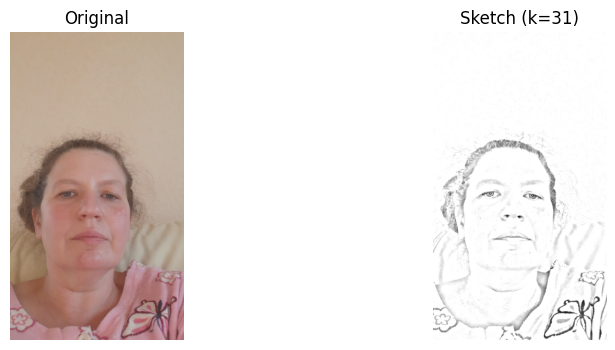

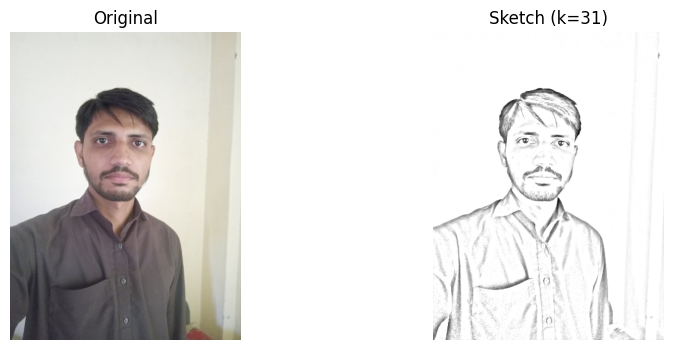

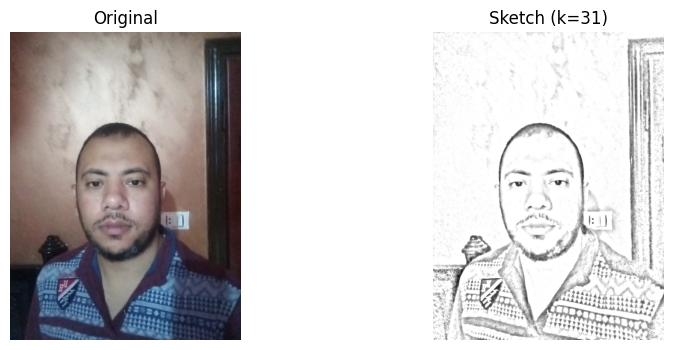

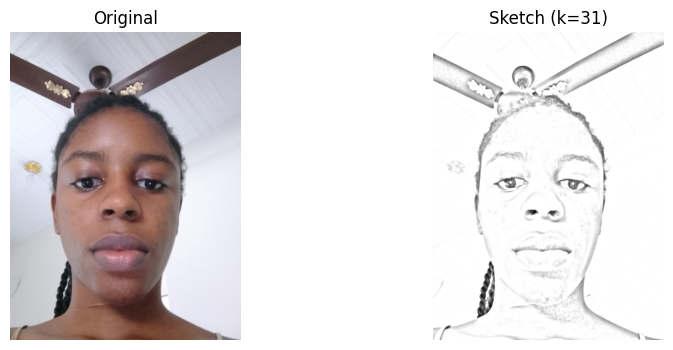

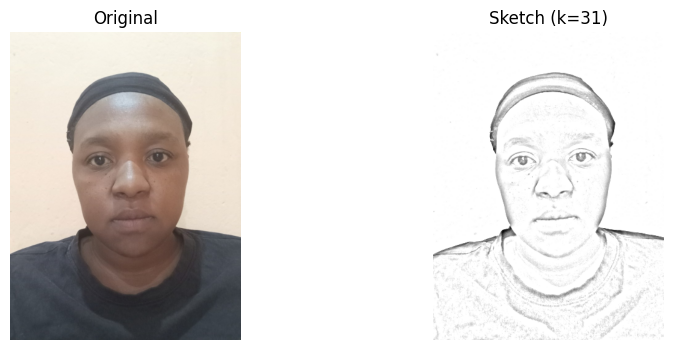

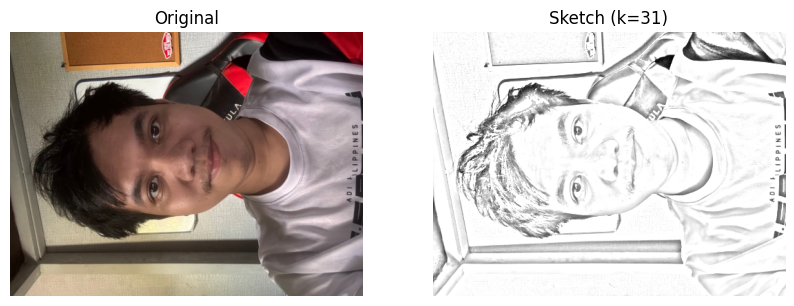

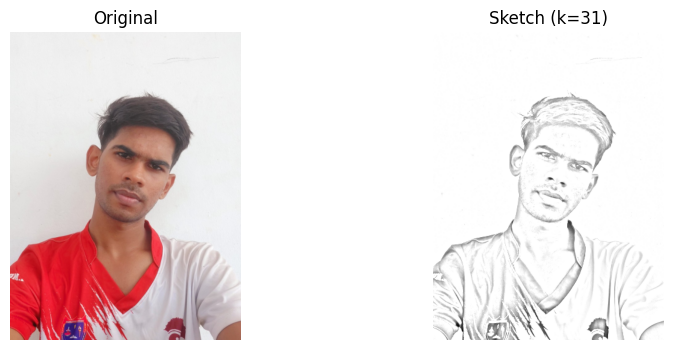

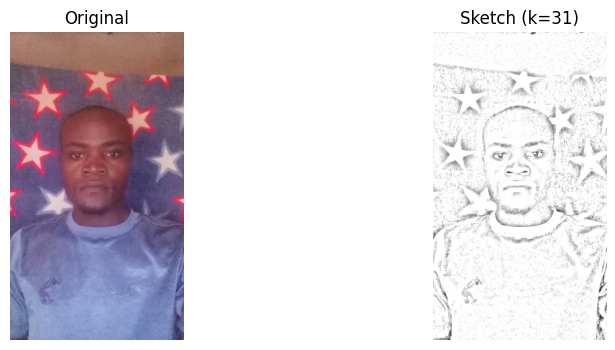

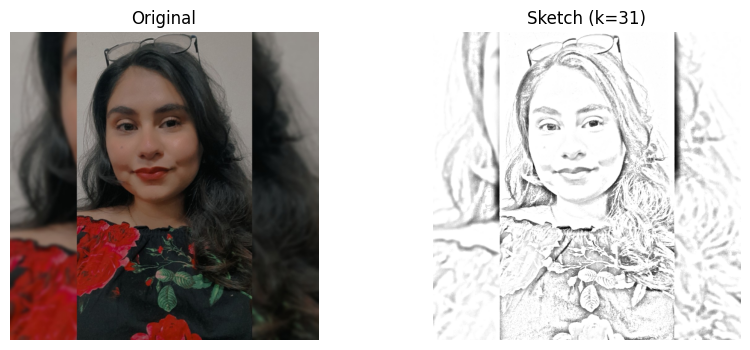

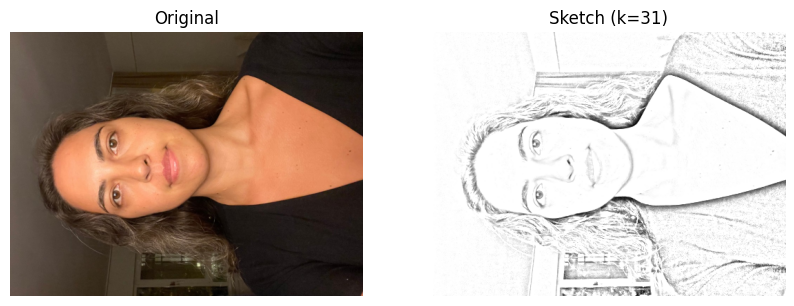

In [112]:
def show_original_and_sketch(path: str, blur_kernel: int = 31, max_size: int | None = 512) -> None:
    """
    Convenience helper to visualize the original selfie and the
    corresponding manual pencil sketch side by side.

    Args:
        path (str): Path to the selfie image on disk.
        blur_kernel (int, optional): Kernel size passed to manual_sketch_from_path().
            Controls edge softness. Defaults to 31.
        max_size (int | None, optional): Optional resize limit for display.
            Passed through to manual_sketch_from_path(). Defaults to 512.

    Side effects:
        - Displays a matplotlib figure with two subplots:
          (left) Original color image, (right) grayscale sketch.
    """
    orig_bgr, sketch = manual_sketch_from_path(path, blur_kernel=blur_kernel, max_size=max_size)
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(sketch, cmap="gray")
    plt.title(f"Sketch (k={blur_kernel})")
    plt.axis("off")

    plt.show()


# Try on first 10 samples
for i in range(10):
    p = get_selfie_path(df.iloc[i], 1)
    show_original_and_sketch(p)


## Create Handmade Components (Lucas' part)
Now, in order to explore the way these libary functions operate, we will rebuild them from scratch. We will then manipulate the factors in order to see how the factors within the calculated functions affect the outcome of the final sketch.

In [109]:
def grayscale_manual(img_bgr: np.ndarray) -> np.ndarray:
    """
    Convert BGR image to grayscale manually using luminosity method, which applies
    a weighted sum of the three color channels.
    """
    B = img_bgr[:, :, 0].astype(np.float32)
    G = img_bgr[:, :, 1].astype(np.float32)
    R = img_bgr[:, :, 2].astype(np.float32)

    gray = 0.114 * B + 0.587 * G + 0.299 * R
    return gray.astype(np.uint8)

def invert_manual(img_gray: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    """
    Create a knob to enable the degree to which the image is inverted.
    alpha=1.0 -> full invert
    alpha between 0-1, partial inversion
    alpha=0.0 -> no invert
    """
    img = img_gray.astype(np.float32)
    full_inv = 255.0 - img
    blended = (1.0 - alpha) * img + alpha * full_inv
    return np.clip(blended, 0, 255).astype(np.uint8)


def gaussian_kernel_manual(size: int, sigma: float) -> np.ndarray:
    """
    Create a 2D Gaussian kernel.

    Args:
        size (int): Kernel size (must be odd).
        sigma (float): Standard deviation of the Gaussian.

    Returns:
        np.ndarray: 2D array of shape (size, size) that sums to 1.
    """

    # Auto-correct kernel size
    if size % 2 == 0:
        print(f"[Info] Kernel size {size} is even, using {size+1} instead.")
        size += 1

    # Coordinate grid centered at 0
    k = size // 2
    x = np.arange(-k, k + 1)
    y = np.arange(-k, k + 1)
    xx, yy = np.meshgrid(x, y)

    # 2D Gaussian formula
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))

    # Normalize so the sum of all weights is 1
    kernel /= kernel.sum()
    return kernel


def dodge_manual(base_gray: np.ndarray, blur_img: np.ndarray) -> np.ndarray:
    """
    Manually implement a dodge blend (like cv2.divide with 255 - blur).

    Args:
        base_gray (np.ndarray): Original grayscale image, uint8 [0, 255].
        blur_img (np.ndarray): Blurred version of inverted grayscale, uint8 [0, 255].

    Returns:
        np.ndarray: Sketch-like grayscale image, uint8 [0, 255].
    """
    # Convert to float for safe division
    base = base_gray.astype(np.float32)
    blur = blur_img.astype(np.float32)

    # Denominator: 255 - blur
    denom = 255.0 - blur

    # Avoid division by zero:
    eps = 1e-6
    denom[denom < eps] = eps

    # Perform the dodge operation
    result = base / denom * 255.0

    # Clip to valid image range and convert back to uint8
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result


def convolve_gray(img_gray: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Convolve a single-channel grayscale image with a 2D kernel.

    Args:
        img_gray (np.ndarray): Grayscale image of shape (H, W).
        kernel (np.ndarray): 2D kernel of shape (kH, kW).

    Returns:
        np.ndarray: Blurred grayscale image of shape (H, W).
    """
    img = img_gray.astype(np.float32)
    kH, kW = kernel.shape
    pad_h = kH // 2
    pad_w = kW // 2

    # Pad the image so we can apply the kernel to border pixels
    # Here we use "reflect" padding
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode="reflect")

    H, W = img.shape
    out = np.zeros_like(img, dtype=np.float32)

    # Naive convolution
    for i in range(H):
        for j in range(W):
            region = padded[i:i + kH, j:j + kW]
            out[i, j] = np.sum(region * kernel)

    # Clip back to valid image range
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def blur_manual(img_gray: np.ndarray, kernel_size: int = 31, sigma: float | None = None) -> np.ndarray:
    """
    Apply Gaussian blur to a grayscale image using a manually computed kernel
    and convolution.
    """
    if sigma is None:
       sigma = kernel_size / 6.0

    kernel = gaussian_kernel_manual(kernel_size, sigma)
    return convolve_gray(img_gray, kernel)



In [108]:
def manual_sketch_from_path_manual(
    path: str,
    blur_kernel: int = 31,
    blur_sigma: float | None = None,
    max_size: int | None = None,
    invert_alpha: float = 1.0,      # new parameter
) -> tuple[np.ndarray, np.ndarray]:
    """
    Full manual sketch pipeline starting from an image path.
    """
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f"Image not found: {path}")

    # Optional resize
    if max_size is not None:
        h, w = img_bgr.shape[:2]
        scale = max_size / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        img_bgr = cv2.resize(img_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 1) Grayscale (manual)
    gray = grayscale_manual(img_bgr)

    # 2) Invert (controlled)
    inv = invert_manual(gray, alpha=invert_alpha)

    # 3) Blur the inverted image (manual Gaussian blur)
    if blur_sigma is None:
        blur_sigma = blur_kernel / 6.0  # heuristic

    blur_img = blur_manual(inv, kernel_size=blur_kernel, sigma=blur_sigma)

    # 4) Dodge blend (manual)
    sketch = dodge_manual(gray, blur_img)

    return img_bgr, sketch


In [113]:
img_path = "/kaggle/input/selfie-and-id-dataset/files/5/Selfie_1.jpg"

test_img = cv2.imread(img_path)
print(type(test_img), test_img.shape if test_img is not None else "Image not found")


<class 'numpy.ndarray'> (1000, 750, 3)


## Isolate a single photo to test a variety of manipulations

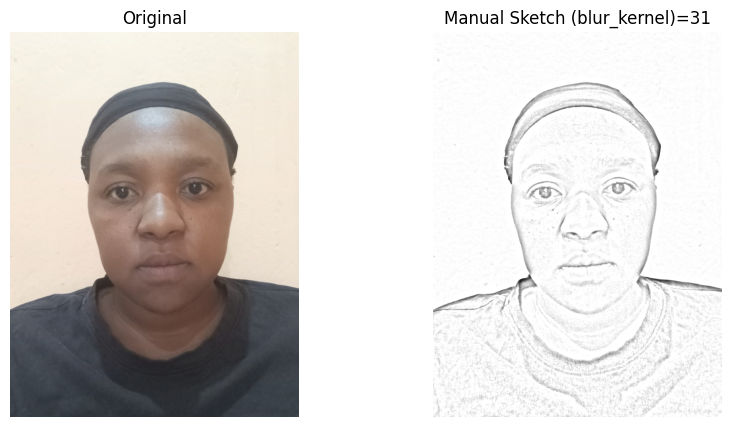

In [114]:

orig_bgr, sketch = manual_sketch_from_path_manual(
    img_path,
    blur_kernel=31,   # blur_kernel set to the openCV default of 31
    blur_sigma=None,  # auto-calculated based on the kernel
    max_size=800     # resizes for speed/display
)

# Convert BGR → RGB for correct display in matplotlib
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(orig_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Manual Sketch (blur_kernel)=31")
plt.imshow(sketch, cmap="gray")
plt.axis("off")

plt.show()


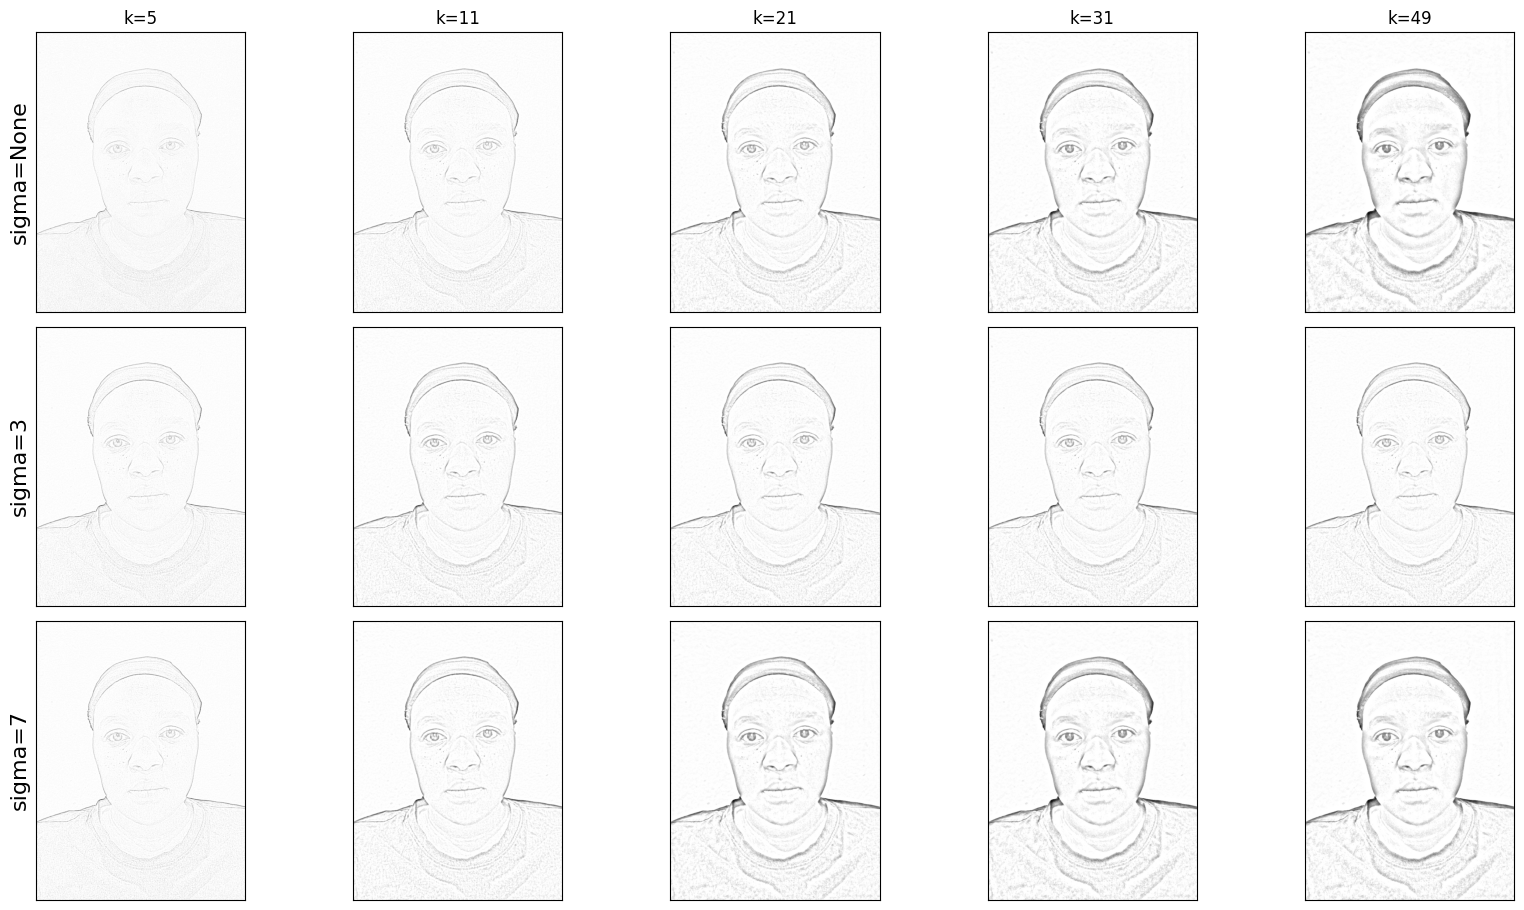

In [115]:
import matplotlib.pyplot as plt

invert_alpha = 1.0   # 100% inversion
k_values = [5, 11, 21, 31, 49]       # 5 kernels = 5 columns
sigma_values = [None, 3, 7]          # 3 sigmas = 3 rows

fig, axes = plt.subplots(
    nrows=len(sigma_values),
    ncols=len(k_values),
    figsize=(18, 10)
)

for row_idx, sigma in enumerate(sigma_values):
    for col_idx, k in enumerate(k_values):
        # Run the manual sketch
        orig_bgr, sketch = manual_sketch_from_path_manual(
            img_path,
            blur_kernel=k,
            blur_sigma=sigma,
            invert_alpha=invert_alpha,
            max_size=800
        )

        ax = axes[row_idx, col_idx]
        ax.imshow(sketch, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])


        # Title logic
        if row_idx == 0:
            ax.set_title(f"k={k}")

        if col_idx == 0:
            ax.set_ylabel(f"sigma={sigma}", fontsize=16)

plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.subplots_adjust(left=0.08)
plt.show()


# Set the same parameters as the previous run, changing only the inversion to alpha 95%

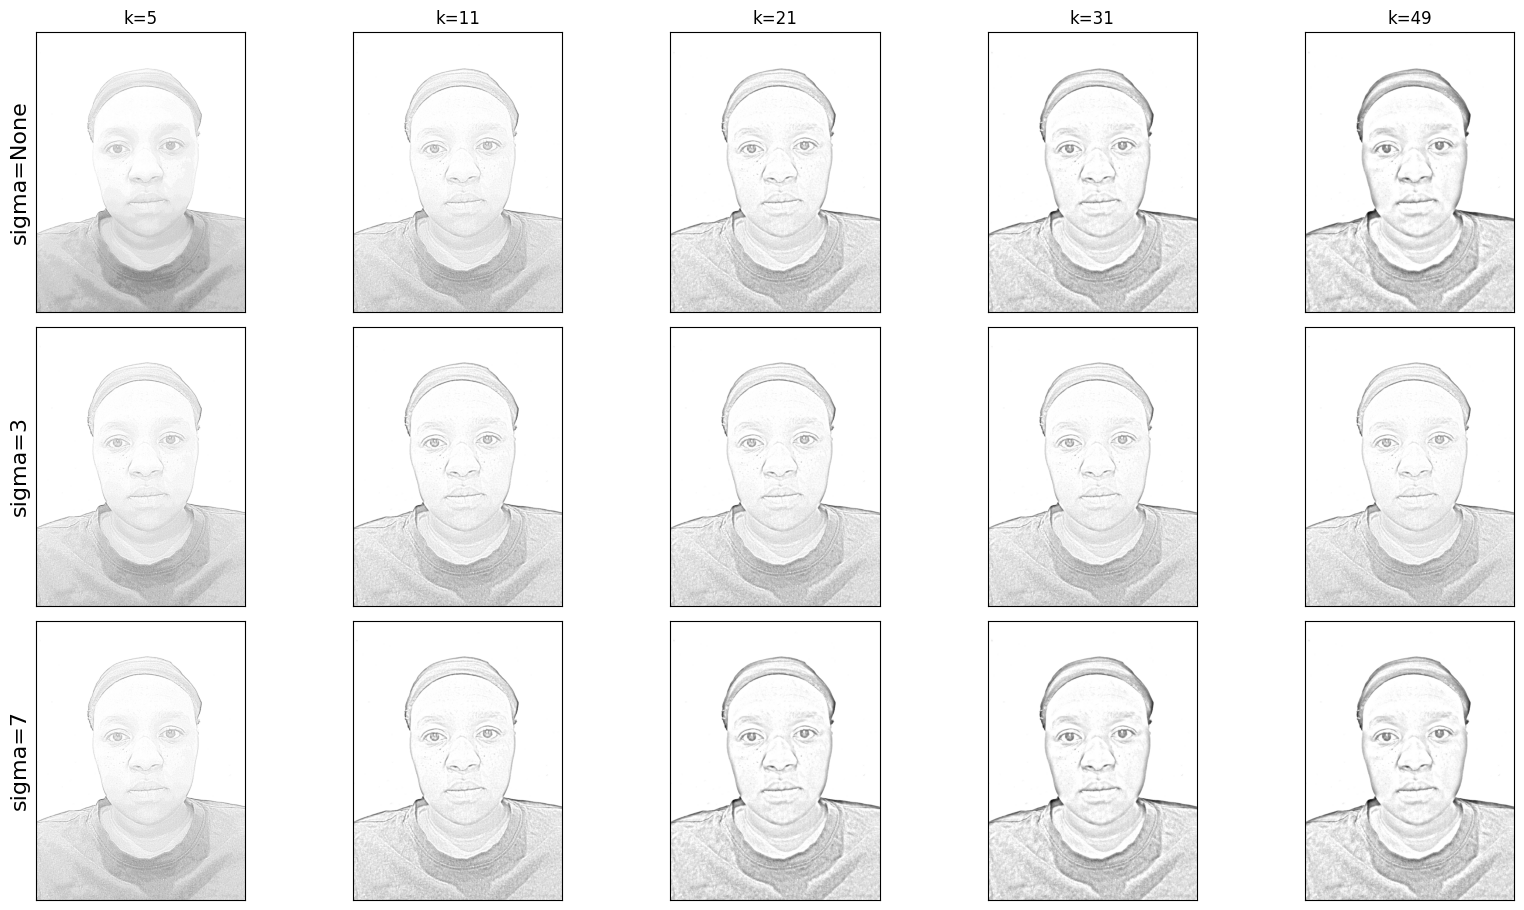

In [120]:
import matplotlib.pyplot as plt

invert_alpha = 0.97   # 97% inversion
k_values = [5, 11, 21, 31, 49]       # 5 kernels = 5 columns
sigma_values = [None, 3, 7]          # 3 sigmas = 3 rows

fig, axes = plt.subplots(
    nrows=len(sigma_values),
    ncols=len(k_values),
    figsize=(18, 10)
)

for row_idx, sigma in enumerate(sigma_values):
    for col_idx, k in enumerate(k_values):
        orig_bgr, sketch = manual_sketch_from_path_manual(
            img_path,
            blur_kernel=k,
            blur_sigma=sigma,
            invert_alpha=invert_alpha,
            max_size=800
        )

        ax = axes[row_idx, col_idx]
        ax.imshow(sketch, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])


        # Title logic
        if row_idx == 0:
            ax.set_title(f"k={k}")

        if col_idx == 0:
            ax.set_ylabel(f"sigma={sigma}", fontsize=16)

plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.subplots_adjust(left=0.08)
plt.show()



## Isolate kernel size, sigma and inversion percentage

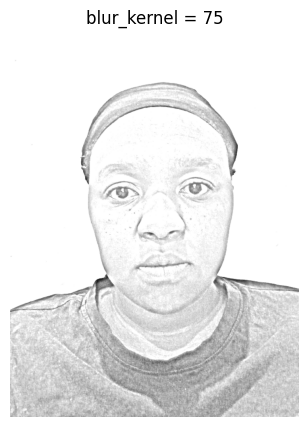

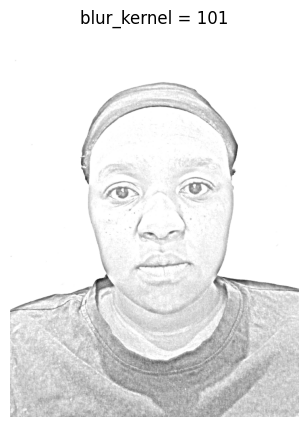

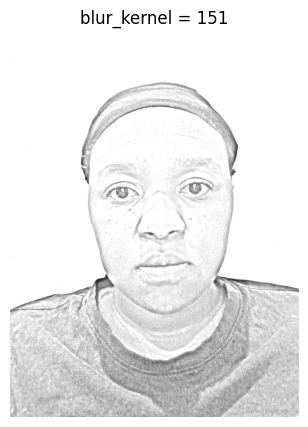

In [117]:
# Kernel size
for k in [75, 101, 151]:
    orig_bgr, sketch = manual_sketch_from_path_manual(
        img_path,
        blur_kernel=k,
        blur_sigma=5,
        max_size=800,
        invert_alpha=0.95
    )
    plt.figure(figsize=(5, 5))
    plt.title(f"blur_kernel = {k}")
    plt.imshow(sketch, cmap="gray")
    plt.axis("off")
    plt.show()

## Try three different sigma's against a kernel of 101

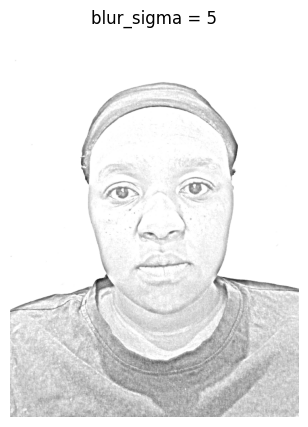

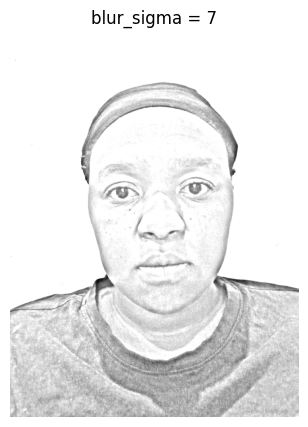

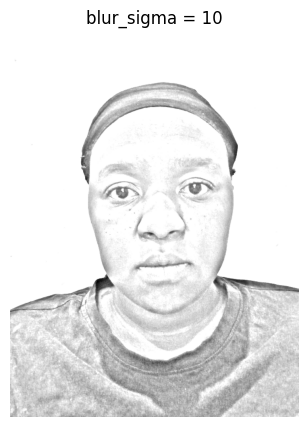

In [118]:
# Sigma
for s in [5, 7, 10]:
    orig_bgr, sketch = manual_sketch_from_path_manual(
        img_path,
        blur_kernel=101,
        blur_sigma=s,
        max_size=800,
        invert_alpha=0.95
    )
    plt.figure(figsize=(5, 5))
    plt.title(f"blur_sigma = {s}")
    plt.imshow(sketch, cmap="gray")
    plt.axis("off")
    plt.show()

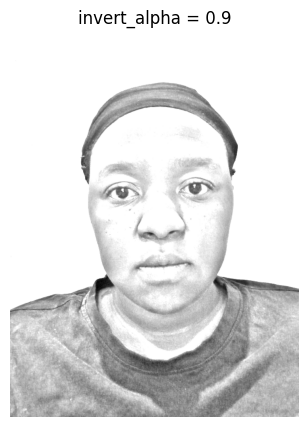

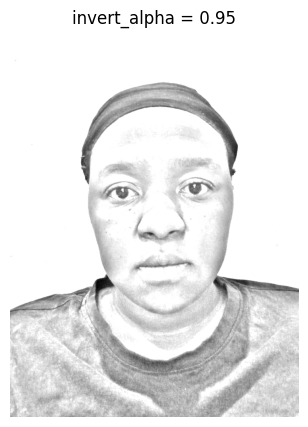

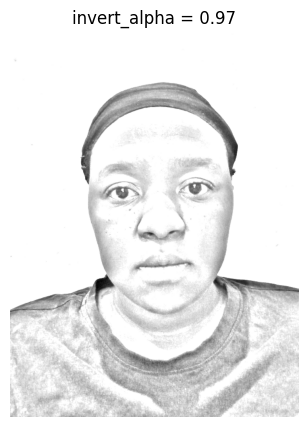

In [122]:
# Inversion percentage
for i in [0.90, 0.95, 0.97]:
    orig_bgr, sketch = manual_sketch_from_path_manual(
        img_path,
        blur_kernel=101,
        blur_sigma=None,
        max_size=800,
        invert_alpha=i
    )
    plt.figure(figsize=(5, 5))
    plt.title(f"invert_alpha = {i}")
    plt.imshow(sketch, cmap="gray")
    plt.axis("off")
    plt.show()

## OpenCV Library Pipeline (Mustafa's part)

OpenCV Library Sketch Pipeline Test:


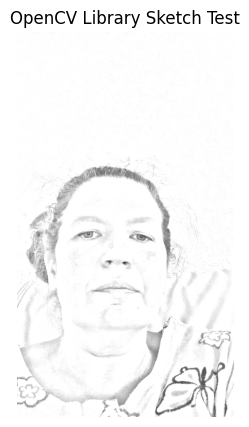

In [89]:
# Import libraries again to ensure they are available in this cell
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import os

# ----------------------------------------------------
# 1. OpenCV Library Pipeline Implementation
# ----------------------------------------------------

def opencv_library_sketch(img_path: str, blur_kernel_size=(101, 101)) -> np.ndarray:
    """
    Converts a color image into a pencil sketch using a direct, compact
    pipeline of standard OpenCV functions.
    """
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Image not found at {img_path}")
        return None

    # 1. Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Invert the grayscale image
    img_invert = cv2.bitwise_not(img_gray)

    # 3. Apply Gaussian blur to the inverted image
    img_blur = cv2.GaussianBlur(img_invert, blur_kernel_size, 0)

    # 4. Color Dodge blend: (Gray / (255 - Blur)) * 256
    sketch_img = cv2.divide(img_gray, 255 - img_blur, scale=256.0)

    return sketch_img

# Test the new function on a sample image
# Assuming 'df' and 'get_selfie_path' are defined.
sample_path = get_selfie_path(df.iloc[0], 1)
new_sketch = opencv_library_sketch(sample_path)

if new_sketch is not None:
    print("OpenCV Library Sketch Pipeline Test:")
    # Use your existing show_original_and_sketch function for visual comparison
    # NOTE: You must also have your 'show_original_and_sketch' function defined.
    # show_original_and_sketch(sample_path, new_sketch, "OpenCV Library Sketch")

    # Display the result using standard Matplotlib (if show_original_and_sketch is missing)
    plt.figure(figsize=(5, 5))
    plt.imshow(new_sketch, cmap="gray")
    plt.title("OpenCV Library Sketch Test")
    plt.axis("off")
    plt.show()

Benchmarking and Comparison

In [90]:
# ----------------------------------------------------
# 2. Benchmarking and Pipeline Comparison
# ----------------------------------------------------

# --- Benchmarking Parameters ---
NUM_SAMPLES = 100 # Number of images to test
sample_df = df.head(NUM_SAMPLES)
kernel_size = 31 # Use a consistent kernel size for both pipelines

# Lists to store timing results
times_manual = []
times_opencv = []

print(f"Starting benchmark on {NUM_SAMPLES} images...")

for index, row in sample_df.iterrows():
    try:
        # Get the path to the first selfie from the set
        path = get_selfie_path(row, 1)

        # --- 1. Benchmark Hand-Crafted Pipeline (Surya's Part) ---
        start_time_manual = time.time()
        # The manual_sketch_from_path function is now correctly defined
        _, _ = manual_sketch_from_path(path, blur_kernel=kernel_size)
        end_time_manual = time.time()
        times_manual.append(end_time_manual - start_time_manual)

        # --- 2. Benchmark OpenCV Library Pipeline (Your Part) ---
        start_time_opencv = time.time()
        _ = opencv_library_sketch(path, blur_kernel_size=(kernel_size, kernel_size))
        end_time_opencv = time.time()
        times_opencv.append(end_time_opencv - start_time_opencv)

    except Exception as e:
        print(f"Skipping set_id {row['set_id']} due to error: {e}")


# --- Display and Analyze Results ---
if times_manual and times_opencv:
    avg_manual = np.mean(times_manual)
    avg_opencv = np.mean(times_opencv)

    print("\n--- Summary of Processing Times ---")
    print(f"Average time (Hand-Crafted Pipeline): {avg_manual:.4f} seconds/image")
    print(f"Average time (OpenCV Library Pipeline): {avg_opencv:.4f} seconds/image")

    # Calculate Speedup
    if avg_manual > avg_opencv:
        speedup = avg_manual / avg_opencv
        print(f"The OpenCV Library Pipeline is approximately {speedup:.2f}x faster.")
    elif avg_opencv > avg_manual:
        speedup = avg_opencv / avg_manual
        print(f"The Hand-Crafted Pipeline is approximately {speedup:.2f}x faster.")
    else:
        print("Both pipelines run at a similar speed.")

Starting benchmark on 100 images...

--- Summary of Processing Times ---
Average time (Hand-Crafted Pipeline): 0.0164 seconds/image
Average time (OpenCV Library Pipeline): 0.0149 seconds/image
The OpenCV Library Pipeline is approximately 1.10x faster.


### Save Sketch Outputs

In [ ]:
output_dir = "/content/outputs/handCrafted"
os.makedirs(output_dir, exist_ok=True)

for i in range(10):
    p = get_selfie_path(df.iloc[i], 1)
    _, sketch = manual_sketch_from_path(p)
    out_path = os.path.join(output_dir, f"set_{df.iloc[i]['set_id']}_selfie1_sketch.png")
    cv2.imwrite(out_path, sketch)
    print("Saved:", out_path)


### Generate PDF

In [ ]:
!apt-get update
!apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-extra

In [ ]:
%shell jupyter nbconvert --to pdf 'Team_Assignment_7_1.ipynb'